In [1]:
%%capture
!pip install torch_geometric

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Generate synthetic data
np.random.seed(42)
n_ships = 10  # Number of ships
engine_power = np.random.uniform(50, 200, n_ships)  # Engine power (feature)
true_speed = 0.5 * engine_power + np.random.normal(0, 10, n_ships)  # True speed (target)

# Create a random graph (e.g., ships are connected if they are within a certain distance)
graph = nx.erdos_renyi_graph(n_ships, p=0.3)  # Random graph with 30% connection probability
edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()

# Node features (engine power)
x = torch.tensor(engine_power, dtype=torch.float).view(-1, 1)

# Target (ship speed)
y = torch.tensor(true_speed, dtype=torch.float)

# Create PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, y=y)

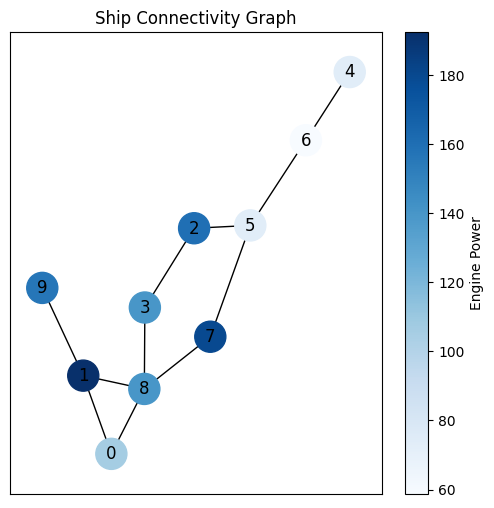

In [3]:
# Visualize the graph
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(graph)  # Layout for the graph
nodes = nx.draw_networkx_nodes(graph, pos, node_color=engine_power, cmap=plt.cm.Blues, node_size=500)
nx.draw_networkx_edges(graph, pos)
nx.draw_networkx_labels(graph, pos)
plt.colorbar(nodes, label="Engine Power")
plt.title("Ship Connectivity Graph")
plt.show()


In [4]:
# Define GNN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(1, 16)  # Input feature size: 1, Output feature size: 16
        self.conv2 = GCNConv(16, 1)  # Output feature size: 1 (predicted speed)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Instantiate the model
model = GCN()

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Training loop
losses = []
for epoch in range(200):
    loss = train()
    losses.append(loss)
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 8565.962890625
Epoch 20, Loss: 1436.5640869140625
Epoch 40, Loss: 1081.51171875
Epoch 60, Loss: 1045.5927734375
Epoch 80, Loss: 1040.2987060546875
Epoch 100, Loss: 1038.491455078125
Epoch 120, Loss: 1037.3951416015625
Epoch 140, Loss: 1036.3563232421875
Epoch 160, Loss: 1035.2479248046875
Epoch 180, Loss: 1034.0701904296875


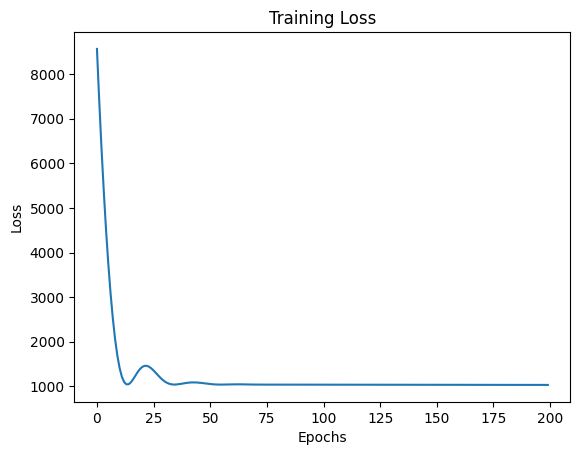

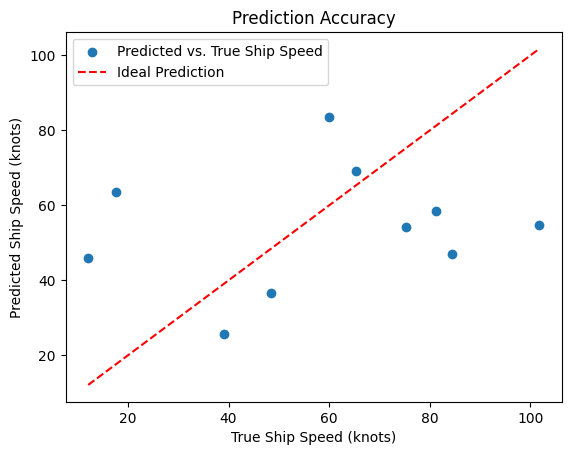

In [5]:


# Plot training loss
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

# Evaluate the model
model.eval()
pred_speed = model(data.x, data.edge_index).detach().numpy()

# Plot true vs. predicted speeds
plt.scatter(true_speed, pred_speed, label="Predicted vs. True Ship Speed")
plt.plot([min(true_speed), max(true_speed)], [min(true_speed), max(true_speed)], 'r--', label="Ideal Prediction")
plt.xlabel("True Ship Speed (knots)")
plt.ylabel("Predicted Ship Speed (knots)")
plt.legend()
plt.title("Prediction Accuracy")
plt.show()
